In [1]:
# In [1]
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
# In [2]
df = pd.read_csv('Xiaomi_clean.csv')   # <-- file của bạn
df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.600000,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.000000,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.500000,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.400000,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.600000,21.799999,19.520000,21.450001,21.450001,364065075
5,2018-07-16,19.940001,21.299999,19.400000,21.049999,21.049999,211621432
6,2018-07-17,21.450001,21.700001,20.549999,20.900000,20.900000,97690237
7,2018-07-18,21.400000,22.200001,21.400000,21.549999,21.549999,142583771
8,2018-07-19,21.700001,21.900000,19.820000,20.100000,20.100000,153563433
9,2018-07-20,20.100000,20.450001,19.500000,19.879999,19.879999,111713800


In [3]:
# In [3]
# Nếu có cột 'Date' chuyển về datetime và set làm index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)


In [4]:
# In [4]
df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-09,16.600000,17.000000,16.000000,16.799999,16.799999,462182642
2018-07-10,17.000000,19.340000,17.000000,19.000000,19.000000,534072218
2018-07-11,18.500000,19.799999,18.299999,19.000000,19.000000,374721138
2018-07-12,19.400000,19.700001,19.020000,19.260000,19.260000,132592630
2018-07-13,19.600000,21.799999,19.520000,21.450001,21.450001,364065075
...,...,...,...,...,...,...
2025-10-22,46.000000,46.740002,45.700001,46.340000,46.340000,121391262
2025-10-23,46.020000,47.080002,45.700001,46.740002,46.740002,106829656
2025-10-24,47.099998,47.400002,45.740002,45.919998,45.919998,170946122


In [5]:
# In [5]
# Select 'Close' column
data = df['Close'].values

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1,1))


In [6]:
# In [6]
# Define sizes
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split
train_data = data_scaled[:train_size]
val_data = data_scaled[train_size: train_size + val_size]
test_data = data_scaled[train_size + val_size : ]

print("Train size:", len(train_data), "Val size:", len(val_data), "Test size:", len(test_data))


Train size: 1260 Val size: 180 Test size: 360


In [7]:
# In [7]
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)


In [8]:
# In [8]
sequence_length = 60

# prepare windows for validation/test so they have preceding context
train_last_windowsize = train_data[-sequence_length:]
val_last_windowsize = val_data[-sequence_length:] if len(val_data) >= sequence_length else np.concatenate([train_last_windowsize[-(sequence_length - len(val_data)):], val_data], axis=0)
test_last_windowsize = test_data[-sequence_length:] if len(test_data) >= sequence_length else np.concatenate([val_data[-(sequence_length - len(test_data)):], test_data], axis=0)

# For training sequences directly from train_data
X_train, y_train = add_data(train_data, sequence_length)
# For validation: extend windows to ensure we can create sequences
val_extended = np.concatenate((train_data[-sequence_length:], val_data), axis=0)
X_val, y_val = add_data(val_extended, sequence_length)

# For test: extend with last part of val to build initial window
test_extended = np.concatenate((val_data[-sequence_length:], test_data), axis=0) if len(val_data) >= sequence_length else np.concatenate((train_data[-sequence_length:], test_data), axis=0)
X_test, y_test = add_data(test_extended, sequence_length)

# reshape to [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# y already shape (n,) -> reshape to (n,1) for consistency
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


X_train shape: (1200, 60, 1) y_train shape: (1200, 1)
X_val shape: (180, 60, 1) y_val shape: (180, 1)
X_test shape: (360, 60, 1) y_test shape: (360, 1)


In [9]:
# In [9]
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


C:\Users\COMPUTER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# In [10]
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32,verbose=2)


Epoch 1/50
38/38 - 13s - 351ms/step - loss: 0.0048 - val_loss: 6.3542e-04
Epoch 2/50
38/38 - 3s - 84ms/step - loss: 0.0015 - val_loss: 6.6713e-04
Epoch 3/50
38/38 - 3s - 84ms/step - loss: 0.0015 - val_loss: 5.8885e-04
Epoch 4/50
38/38 - 3s - 84ms/step - loss: 0.0013 - val_loss: 4.9922e-04
Epoch 5/50
38/38 - 5s - 138ms/step - loss: 0.0011 - val_loss: 4.3609e-04
Epoch 6/50
38/38 - 5s - 140ms/step - loss: 0.0011 - val_loss: 3.8678e-04
Epoch 7/50
38/38 - 3s - 84ms/step - loss: 9.9071e-04 - val_loss: 4.2293e-04
Epoch 8/50
38/38 - 3s - 84ms/step - loss: 0.0011 - val_loss: 3.7654e-04
Epoch 9/50
38/38 - 3s - 87ms/step - loss: 8.8330e-04 - val_loss: 3.7694e-04
Epoch 10/50
38/38 - 3s - 86ms/step - loss: 9.7855e-04 - val_loss: 3.1458e-04
Epoch 11/50
38/38 - 5s - 135ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 12/50
38/38 - 5s - 135ms/step - loss: 0.0012 - val_loss: 2.8893e-04
Epoch 13/50
38/38 - 5s - 141ms/step - loss: 8.0357e-04 - val_loss: 2.8112e-04
Epoch 14/50
38/38 - 3s - 87ms/step - loss

In [11]:
# In [11]
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [12]:
# In [12]
# Đảm bảo reshape đúng trước khi inverse_transform
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))

# Original series (inverse transform scaled arrays)
train_data_inv = scaler.inverse_transform(train_data.reshape(-1,1))
test_data_inv = scaler.inverse_transform(test_data.reshape(-1,1))
val_data_inv = scaler.inverse_transform(val_data.reshape(-1,1))

# Lưu y_test và y_val ở dạng gốc để tính lỗi
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))


In [13]:
# In [13]
# Metrics on Test set
test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_inv)
test_rmse = np.sqrt(test_mse)
# MSLE can fail if negatives — ensure positive (stock prices positive normally)
test_msle = mean_squared_log_error(y_test_inv.clip(min=0), y_pred_inv.clip(min=0))

print("MAPE on Test set: ", test_mape)
print("RMSE on Test set: ", test_rmse)
print("MSLE on Test set: ", test_msle)

# Metrics on Validate set
val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val_inv.clip(min=0), y_pred_val_inv.clip(min=0))

print("MAPE on Validate set: ", val_mape)
print("RMSE on Validate set: ", val_rmse)
print("MSLE on Validate set: ", val_msle)


MAPE on Test set:  0.037811651032773605
RMSE on Test set:  2.169517959157193
MSLE on Test set:  0.0022148615905801757
MAPE on Validate set:  0.029675431267380967
RMSE on Validate set:  0.5473477245877293
MSLE on Validate set:  0.0012663449082045348


In [14]:
# In [14]
# Lấy last sequence từ data_scaled (toàn bộ series)
last_sequence_days = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)

y_next_30_days_scaled = []
current_sequence = last_sequence_days.copy()

for i in range(30):
    next_pred_scaled = model.predict(current_sequence)  # shape (1,1)
    y_next_30_days_scaled.append(next_pred_scaled[0,0])
    # cập nhật current_sequence: bỏ đầu + thêm predict
    next_val = np.array(next_pred_scaled).reshape(1,1,1)
    current_sequence = np.concatenate((current_sequence[:,1:,:], next_val), axis=1)

# inverse transform next 30 days
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days_scaled).reshape(-1,1))
print(y_next_30_days.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

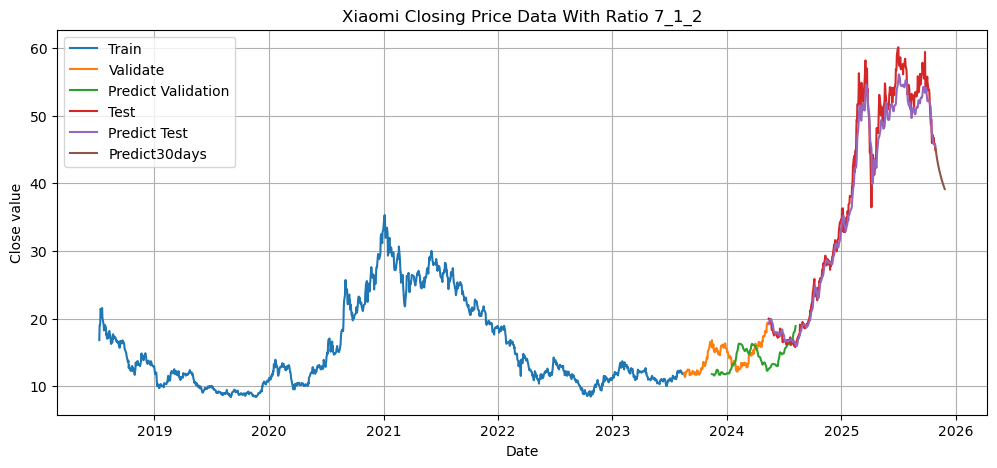

In [16]:
# In [15]
plt.figure(figsize=(12,5))

# Train set plot (use index slices)
plt.plot(df.index[:train_size], train_data_inv, label='Train')

# Validation set (index)
val_index = df.index[train_size: train_size + val_size]
plt.plot(val_index, val_data_inv, label='Validate')

# Predict on validation: need indices aligned to val_index (may be shorter by sequence_length)
# For plotting predicted validation we used val_extended => its predictions correspond to positions starting at train_size + 0 ... we align by taking appropriate slice
pred_val_index = df.index[train_size + sequence_length : train_size + sequence_length + len(y_pred_val_inv)]
pred_val_index = pred_val_index[:len(y_pred_val_inv)]
plt.plot(pred_val_index, y_pred_val_inv.flatten(), label='Predict Validation')

# Test set
test_index = df.index[train_size + val_size : train_size + val_size + len(test_data_inv)]
plt.plot(test_index, test_data_inv, label='Test')

# Predict on test: **fix** bằng cách lấy đúng số index tương ứng với y_pred_inv
pred_test_index = df.index[-len(y_pred_inv):]
plt.plot(pred_test_index, y_pred_inv.flatten(), label='Predict Test')

# Next 30 days: generate an index starting the day after last df index (if index is datetime)
if isinstance(df.index, pd.DatetimeIndex):
    last_date = df.index[-1]
    index_next_30_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
else:
    index_next_30_days = range(len(df), len(df) + 30)

plt.plot(index_next_30_days, y_next_30_days.flatten(), label='Predict30days')

plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("Xiaomi Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_Xiaomi.png')
plt.show()